Discussion: Comparison of Models

This assignment implemented and evaluated four key modeling approaches: linear regression, logistic regression (trained with gradient descent and Newton’s method), and decision trees (classification and regression). Their comparative performance across the Wine, Banknote, and Iris datasets illustrates tradeoffs between model complexity, interpretability, and generalization.

Linear Regression (Wine dataset) assumes a linear relationship between predictors and the target variable. Both the closed-form solution and gradient descent converged to nearly identical results, with test performance around MSE ≈ 0.385 and R² ≈ 0.33. While efficient and interpretable, linear regression underfits when data contain nonlinear interactions. Its strength lies in transparency of coefficients and computational simplicity, but its limited flexibility reduces predictive accuracy for complex datasets.

Logistic Regression (Banknote dataset) models class probabilities via the logistic sigmoid function. Two optimization strategies were applied:

Gradient Descent (GD): produced high test accuracy (≈ 98.2%) and strong precision/recall. GD is straightforward to implement but requires careful tuning of learning rate and iterations for convergence.

Newton’s Method (Iteratively Reweighted Least Squares): achieved slightly better performance (≈ 99.3% accuracy, perfect recall) with far fewer iterations. By leveraging second-order information, Newton’s method converges faster and more precisely, though at higher per-iteration computational cost due to matrix inversions.

This comparison highlights the tradeoff between GD’s scalability and Newton’s rapid convergence on well-conditioned problems.

Decision Trees partition the feature space into homogeneous regions using simple threshold rules. On the Iris dataset, a classification tree achieved ≈ 96.7% accuracy, effectively capturing nonlinear boundaries between classes. On the Wine dataset, however, the regression tree underperformed compared to linear regression (test R² ≈ 0.26 vs. 0.33), showing susceptibility to overfitting and variance when sample sizes are limited. Trees are highly interpretable and capture feature interactions naturally, but require pruning or ensembles to generalize robustly.

The results demonstrate that model choice depends on data complexity: regression models are well-suited for linear relationships, while tree-based methods are advantageous when decision boundaries are nonlinear.

# (0) Wine Dataset - EDA & preprocessing

In [135]:
"""     a. Load each dataset.
        b. Handle missing values (drop/justify). 
        c. Print shapes and class/target summaries.
"""
# --- a. Load Wine Dataset
print("\n$Loading dataset\n.")
import pandas as pd
data_path = 'winequality-red.csv'
raw_df = pd.read_csv(data_path, sep=';')
print("..")
# --- b. Handle missing values
print("\n$Handling Missing values\n")
print("Missing values per column:")
print(raw_df.isna().sum())
df = raw_df.dropna()
# --- c. Print shapes and class/target summaries.
print("\n$Printing shapes and target summaries\n")
print("Dataset shape:", df.shape)
print("Dataset shape after dropping missing:", df.shape)
print(df['quality'].describe())



        


$Loading dataset
.
..

$Handling Missing values

Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

$Printing shapes and target summaries

Dataset shape: (1599, 12)
Dataset shape after dropping missing: (1599, 12)
count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64


In [136]:
"""
     Compute basic stats (mean/median/std/min/max) for numeric features.
"""
def analyze_all_columns(dataframe):
  """
  Iterates through all columns of a DataFrame and analyzes each one.

  Args:
    dataframe (pd.DataFrame): The DataFrame to analyze.
  """
  # This helper function is nested to keep the code organized
  def _analyze_column(df, col_name):
    """
    Checks if a column is numeric and, if so, computes descriptive statistics.
    """
    if pd.api.types.is_numeric_dtype(df[col_name]):
      print(f"Column '{col_name}' is numeric. Computing statistics...\n")
      
      # Compute the statistics
      stats = {
          "Mean": df[col_name].mean(),
          "Median": df[col_name].median(),
          "Standard Deviation": df[col_name].std(),
          "Minimum": df[col_name].min(),
          "Maximum": df[col_name].max()
      }
      
      # Print the results
      print(f"Statistics for column '{col_name}':")
      for stat, value in stats.items():
        print(f"  - {stat}: {value:.4f}")
      print("\n" + "-"*30 + "\n")
    else:
      print(f"Column '{col_name}' is not numeric. Skipping statistics calculation.\n")
  
  for col in dataframe.columns:
    _analyze_column(dataframe, col)
# Analyze all columns in the DataFrame
analyze_all_columns(df)


Column 'fixed acidity' is numeric. Computing statistics...

Statistics for column 'fixed acidity':
  - Mean: 8.3196
  - Median: 7.9000
  - Standard Deviation: 1.7411
  - Minimum: 4.6000
  - Maximum: 15.9000

------------------------------

Column 'volatile acidity' is numeric. Computing statistics...

Statistics for column 'volatile acidity':
  - Mean: 0.5278
  - Median: 0.5200
  - Standard Deviation: 0.1791
  - Minimum: 0.1200
  - Maximum: 1.5800

------------------------------

Column 'citric acid' is numeric. Computing statistics...

Statistics for column 'citric acid':
  - Mean: 0.2710
  - Median: 0.2600
  - Standard Deviation: 0.1948
  - Minimum: 0.0000
  - Maximum: 1.0000

------------------------------

Column 'residual sugar' is numeric. Computing statistics...

Statistics for column 'residual sugar':
  - Mean: 2.5388
  - Median: 2.2000
  - Standard Deviation: 1.4099
  - Minimum: 0.9000
  - Maximum: 15.5000

------------------------------

Column 'chlorides' is numeric. Computi

In [137]:
"""
     Train/test split once per dataset (80/20, fixed seeds). Standardize using train stats only.
"""
import numpy as np

def add_intercept(X):
    """
    Return X with a leading column of ones (bias term).
    X: (n_samples, n_features) -> (n_samples, n_features + 1)
    Notes: ensure float dtype; do not modify X in-place.
    """
    X_out = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_out.astype(float)

def standardize_fit(X_train, eps=1e-12):
    """
    Standardize TRAIN features to zero mean / unit variance.
    Return (Xs, mean, std). Use only TRAIN stats.
    """
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_standardized = (X_train - mean) / (std + eps)
    return X_standardized, mean, std

def standardize_apply(X, mean, std, eps=1e-12):
    """
    [cite_start]Apply TRAIN (mean, std) to any new matrix X[cite: 32].
    [cite_start]Do not recompute mean/std here[cite: 32].
    """
    return (X - mean) / (std + eps)

def train_test_split_idx(n, test_size, seed=0):
    """
    Apply TRAIN (mean, std) to any new matrix X.
    Do not recompute mean/std here.
    """
    # Set the random seed for reproducibility
    print("Random Seed: ",seed) 
    np.random.seed(seed)
    
    # Calculate the number of samples for the test set
    n_test = int(n * test_size)
    
    # Create an array of indices from 0 to n-1
    indices = np.arange(n)
    
    # Shuffle the indices
    np.random.shuffle(indices)
    
    # Split the shuffled indices into test and train sets
    test_idx = indices[:n_test]
    train_idx = indices[n_test:]
    
    return train_idx, test_idx

X = df.drop('quality', axis=1).values
y = df['quality'].values

# Train/test split using the custom function
n_samples = X.shape[0]
train_idx, test_idx = train_test_split_idx(n_samples, test_size=0.2, seed=0)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Standardize features using train stats only
X_train_std, mean_train, std_train = standardize_fit(X_train)
X_test_std = standardize_apply(X_test, mean_train, std_train)
print(f"Training dataset: {X_train_std.shape} Testing dataset: {X_test_std.shape}")


Random Seed:  0
Training dataset: (1280, 11) Testing dataset: (319, 11)


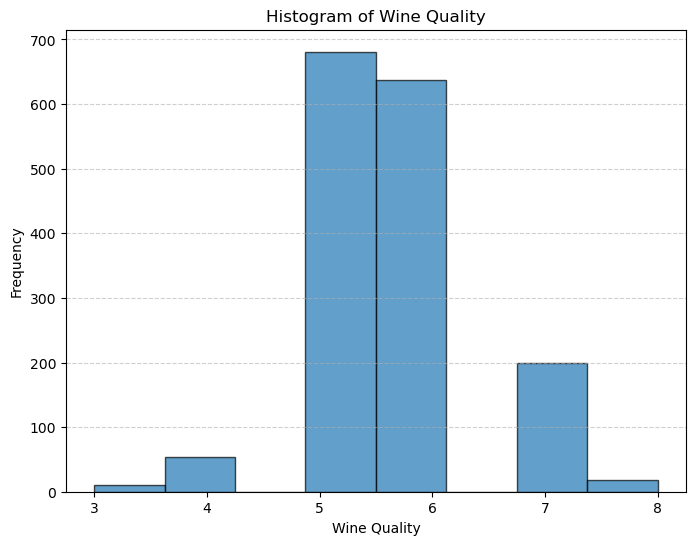

In [138]:
"""
     Produce 2–3 plots per dataset (histograms / pairwise scatter / boxplots) and describe any outliers/skew.
"""
import matplotlib.pyplot as plt

# Histogram of Wine Quality
plt.figure(figsize=(8, 6))
plt.hist(df['quality'], bins=8, edgecolor='black', alpha=0.7)
plt.title('Histogram of Wine Quality')
plt.xlabel('Wine Quality')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

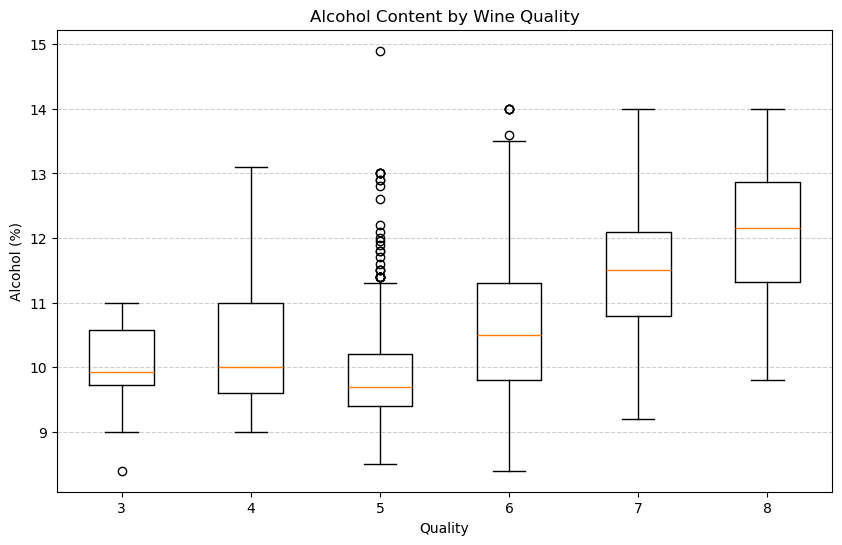

In [139]:
# Box Plot of wine quality and alcohol content
# To plot 'alcohol' for each unique 'quality' group
quality_groups = sorted(df['quality'].unique())
data_to_plot = [df[df['quality'] == q]['alcohol'] for q in quality_groups]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, tick_labels=quality_groups)
plt.title('Alcohol Content by Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Alcohol (%)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Selecting Most and least correlated column with quality
quality           1.000000
alcohol           0.476166
residual sugar    0.013732
Name: quality, dtype: float64


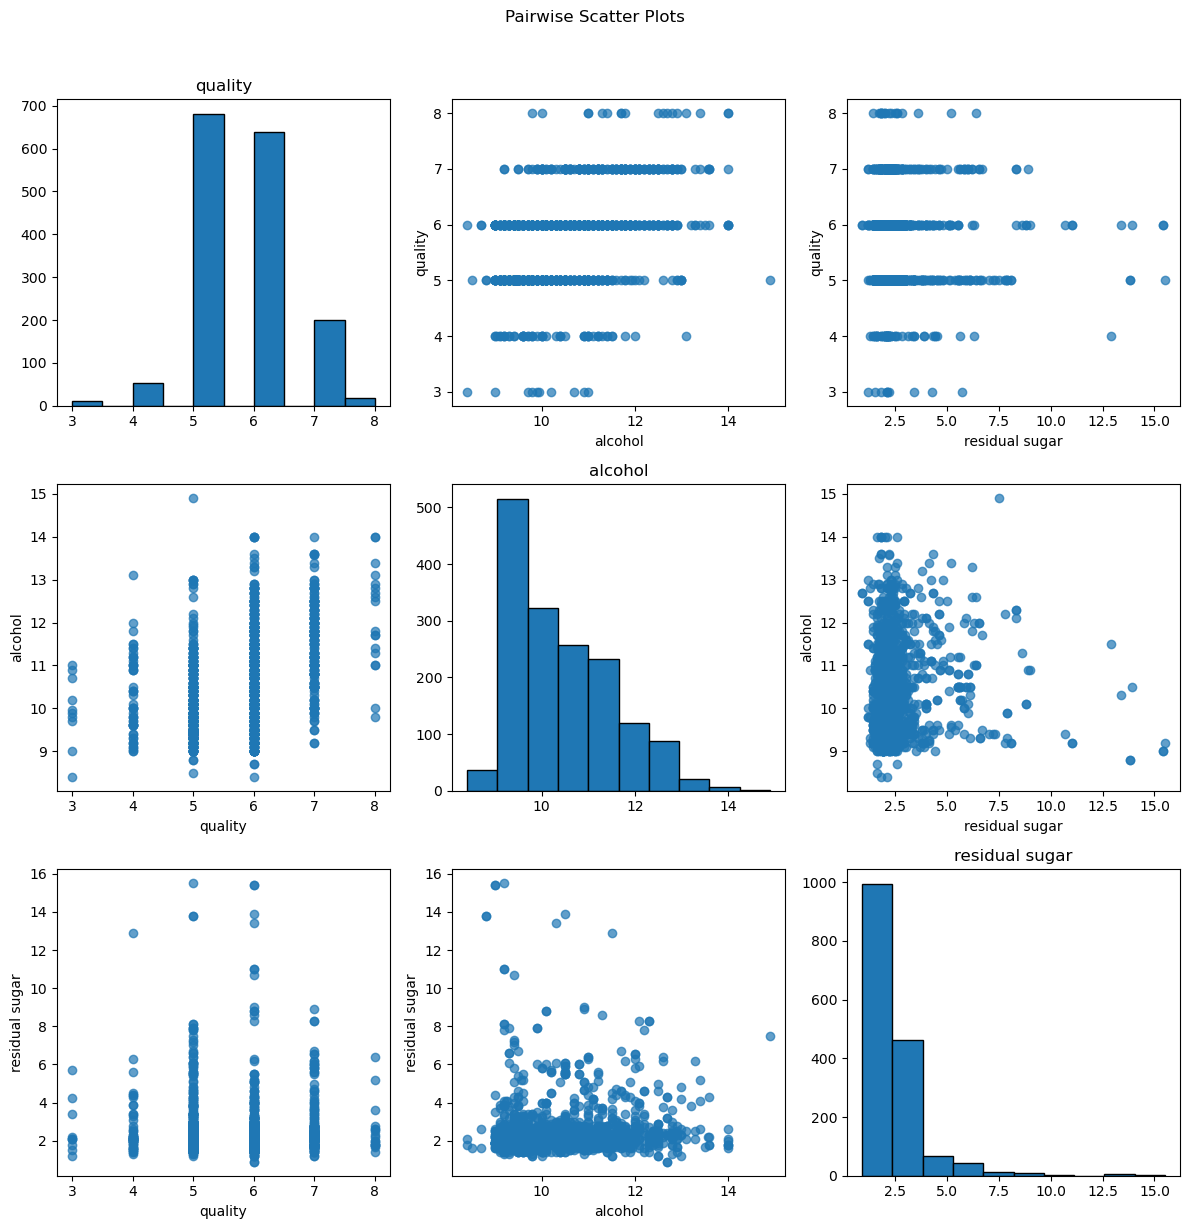

In [140]:
# Calculate the correlation matrix
corr_matrix = df.corr()
quality_correlations = corr_matrix['quality']
descending_correlated_features = quality_correlations.abs().sort_values(ascending=False)
three_features = descending_correlated_features.iloc[[0,1,-1]]
print("Selecting Most and least correlated column with quality")
print(three_features)
# 3. Get the list of column names from the Series index
columns_to_select = three_features.index.tolist()
new_df = df[columns_to_select]

# Pairwise scatter Plot
features =  new_df.columns.tolist()
n_features = len(features)
fig, axes = plt.subplots(n_features, n_features, figsize=(12, 12))

for i in range(n_features):
    for j in range(n_features):
        if i == j:
            # Plot histogram on the diagonal
            axes[i, j].hist(new_df[features[i]], bins=10, edgecolor='black')
            axes[i, j].set_title(features[i])
        else:
            # Plot scatter plot for off-diagonal
            axes[i, j].scatter(new_df[features[j]], new_df[features[i]], alpha=0.7)
            axes[i, j].set_xlabel(features[j])
            axes[i, j].set_ylabel(features[i])

plt.suptitle('Pairwise Scatter Plots', y=1.02)
plt.tight_layout()
plt.show()

# 1) Linear Regression via MLE on Wine (25 pts)


$ Closed form Loss and R^2 for training and testing

Closed-form MSE (Train): 0.4256
Closed-form MSE (Test): 0.3852

Closed-form R^2 (Train): 0.3654
Closed-form R^2 (Test): 0.3286
Closed-form Weight Vector: [ 5.646875    0.07251889 -0.20942866 -0.03492666  0.04067697 -0.08974311
  0.02846893 -0.09315737 -0.06000062 -0.03860717  0.16198752  0.28344618]

$ GD Loss and R^2 for training and testing

GD MSE (Train): 0.4256
GD MSE (Test): 0.3852

GD R^2 (Train): 0.4256
GD R^2 (Test): 0.3286
GD Weight vector: [ 5.646875    0.07375155 -0.20926837 -0.03482901  0.04111393 -0.08971745
  0.02844326 -0.09314372 -0.06129106 -0.03790011  0.16219733  0.28266921]


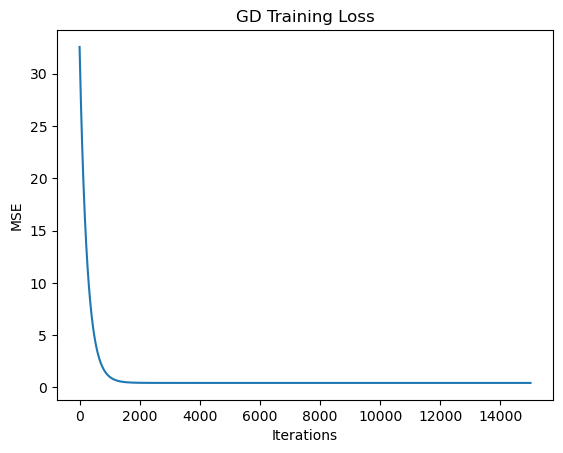

In [141]:
# --- Task 1: Linear Regression (MLE) on Wine ---

# --- Linear Regression (MLE) Functions ---

def mse(y, yhat):
    """Mean squared error: average of (y-yhat)^2 (1D arrays)."""
    return np.mean((y - yhat)**2)

def r2_score(y, yhat):
    """
    SS_res/SS_tot; handle constant-y edge case safely.
    SS_res = sum((y - yhat)^2)
    SS_tot = sum((y - mean(y))^2)
    R^2 = 1 - (SS_res / SS_tot)
    """
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    if ss_tot == 0:
        return 1.0
    return 1 - (ss_res / ss_tot)

def fit_linear_closed_form(X, y, add_bias=True, rcond=None):
    """
    Closed-form least squares (MLE) using pseudoinverse or solve.
    *If add_bias: prepend ones.
    *Prefer pinv for numerical stability when X^T X is ill-conditioned.
    Return w (length p [+1 if bias]).
    """
    if add_bias:
        X = add_intercept(X)
    w = np.linalg.pinv(X.T @ X) @ X.T @ y
    return w

def fit_linear_gd(X, y, lr=0.001, iters=15000, add_bias=True):
    """
    Batch gradient descent for least squares.
    Return (w, losses).
    """
    if add_bias:
        X = add_intercept(X)
    n, p = X.shape
    w = np.zeros(p)
    losses = []
    for _ in range(iters):
        yhat = X @ w
        gradient = (2 / n) * X.T @ (yhat - y)
        w -= lr * gradient
        losses.append(mse(y, yhat))
    return w, losses

def predict_linear(X, w, has_bias=True):
    """Predict with linear model; add bias column if has_bias. Return 1D yhat."""
    if has_bias:
        X = add_intercept(X)
    return X @ w
""" 
    Implement closed-form and GD solvers. Plot GD training loss and discuss convergence behaviour.
"""

# Closed-form solution
w_closed_form = fit_linear_closed_form(X_train_std, y_train)
yhat_train_cf = predict_linear(X_train_std, w_closed_form)
yhat_test_cf = predict_linear(X_test_std, w_closed_form)
print("\n$ Closed form Loss and R^2 for training and testing\n")
print(f"Closed-form MSE (Train): {mse(y_train, yhat_train_cf):.4f}")
print(f"Closed-form MSE (Test): {mse(y_test, yhat_test_cf):.4f}\n")
print(f"Closed-form R^2 (Train): {r2_score(y_train, yhat_train_cf):.4f}")
print(f"Closed-form R^2 (Test): {r2_score(y_test, yhat_test_cf):.4f}")
print(f"Closed-form Weight Vector: {w_closed_form}")

# Gradient descent solution
w_gd, gd_losses = fit_linear_gd(X_train_std, y_train)
yhat_train_gd = predict_linear(X_train_std, w_gd)
yhat_test_gd = predict_linear(X_test_std, w_gd)
print("\n$ GD Loss and R^2 for training and testing\n")
print(f"GD MSE (Train): {mse(y_train, yhat_train_gd):.4f}")
print(f"GD MSE (Test): {mse(y_test, yhat_test_gd):.4f}\n")
print(f"GD R^2 (Train): {mse(y_train, yhat_train_gd):.4f}")
print(f"GD R^2 (Test): {r2_score(y_test, yhat_test_gd):.4f}")
print(f"GD Weight vector: {w_gd}")

"""
    • Report MSE and R2 on train/test; compare coefficient vectors and interpret influential features.
"""

# Plot GD training loss
plt.figure()
plt.plot(gd_losses)
plt.title("GD Training Loss")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [142]:
""" Sanity check: verify GD gradient with finite differences on 3 random coordinates (±10−5 ).
"""

def analytical_gradient(X, y, w):
    """
    Compute the analytical gradient of the MSE loss
    with respect to weights w.

    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input feature matrix.
    y : ndarray of shape (n_samples,)
        Target values.
    w : ndarray of shape (n_features,)
        Current weight vector.

    Returns
    -------
    gradient : ndarray of shape (n_features,)
        Analytical gradient of the loss w.r.t. w.
    """
    n = X.shape[0]  # number of samples
    yhat = X @ w    # predictions
    gradient = (2 / n) * X.T @ (yhat - y)
    return gradient



def numerical_gradient(X, y, w, epsilon=1e-5):
    """
    Compute the numerical gradient of the MSE loss with respect to weights w using the central difference formula.

    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input feature matrix.
    y : ndarray of shape (n_samples,)
        Target values.
    w : ndarray of shape (n_features,)
        Current weight vector.
    epsilon : float, optional (default=1e-5)
        Small perturbation value for finite differences.

    Returns
    -------
    num_gradient : ndarray of shape (n_features,)
        Numerical gradient of the loss w.r.t. w.
    """
    num_gradient = np.zeros_like(w)
    for i in range(len(w)):
        w_plus = np.copy(w)
        w_minus = np.copy(w)
        w_plus[i] += epsilon
        w_minus[i] -= epsilon

        # Compute loss at perturbed weights
        J_plus = np.mean((X @ w_plus - y) ** 2)
        J_minus = np.mean((X @ w_minus - y) ** 2)

        # Central difference formula
        num_gradient[i] = (J_plus - J_minus) / (2 * epsilon)

    return num_gradient

def sanity_check(X, y, w, num_coords=3, epsilon=1e-5):
    """
    Compare analytical gradient with numerical gradient on a few random coordinates.
    """
    # Compute both gradients
    grad_analytical = analytical_gradient(X, y, w)
    grad_numerical = numerical_gradient(X, y, w, epsilon)

    # Pick random coordinates
    idxs = np.random.choice(len(w), size=num_coords, replace=False)

    print("Sanity check on random coordinates:")
    for i in idxs:
        print(f"Coordinate {i}:")
        print(f"  Analytical: {grad_analytical[i]:.6f}")
        print(f"  Numerical : {grad_numerical[i]:.6f}")
        print(f"  Difference: {abs(grad_analytical[i] - grad_numerical[i]):.6e}\n")
print(" Sanity check using random training samples ")
indices = np.random.choice(X_train_std.shape[0], 3, replace=False)
X_sample = add_intercept(X_train_std[indices])
y_sample = y_train[indices]
sanity_check(X_sample, y_sample, w_gd)

 Sanity check using random training samples 
Sanity check on random coordinates:
Coordinate 3:
  Analytical: -0.188536
  Numerical : -0.188536
  Difference: 2.311540e-12

Coordinate 1:
  Analytical: -2.564635
  Numerical : -2.564635
  Difference: 7.445600e-12

Coordinate 0:
  Analytical: -0.022607
  Numerical : -0.022607
  Difference: 1.681537e-13



# (0) Banknote Dataset - EDA & preprocessing

In [143]:
"""     a. Load each dataset.
        b. Handle missing values (drop/justify). 
        c. Print shapes and class/target summaries.
"""
# --- a. Load Banknote Dataset
print("\n$Loading dataset\n.")
import pandas as pd
# Load the data (comma-separated values)
raw_df = pd.read_csv("data_banknote_authentication.txt", header=None)
raw_df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]
print("..")
# --- b. Handle missing values
print("\n$Handling Missing values\n")
print("Missing values per column:")
print(raw_df.isna().sum())
df = raw_df.dropna()
# --- c. Print shapes and class/target summaries.
print("\n$Printing shapes and target summaries\n")
print("Dataset shape:", df.shape)
print("Dataset shape after dropping missing:", df.shape)
#print(df.iloc[4].describe())
class_col = 4
print(df.iloc[:, class_col].describe())




        


$Loading dataset
.
..

$Handling Missing values

Missing values per column:
variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

$Printing shapes and target summaries

Dataset shape: (1372, 5)
Dataset shape after dropping missing: (1372, 5)
count    1372.000000
mean        0.444606
std         0.497103
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: class, dtype: float64


In [144]:
"""
     Compute basic stats (mean/median/std/min/max) for numeric features.
"""
def analyze_all_columns(dataframe):
  """
  Iterates through all columns of a DataFrame and analyzes each one.

  Args:
    dataframe (pd.DataFrame): The DataFrame to analyze.
  """
  # This helper function is nested to keep the code organized
  def _analyze_column(df, col_name):
    """
    Checks if a column is numeric and, if so, computes descriptive statistics.
    """
    if pd.api.types.is_numeric_dtype(df[col_name]):
      print(f"Column '{col_name}' is numeric. Computing statistics...\n")
      
      # Compute the statistics
      stats = {
          "Mean": df[col_name].mean(),
          "Median": df[col_name].median(),
          "Standard Deviation": df[col_name].std(),
          "Minimum": df[col_name].min(),
          "Maximum": df[col_name].max()
      }
      
      # Print the results
      print(f"Statistics for column '{col_name}':")
      for stat, value in stats.items():
        print(f"  - {stat}: {value:.4f}")
      print("\n" + "-"*30 + "\n")
    else:
      print(f"Column '{col_name}' is not numeric. Skipping statistics calculation.\n")
  
  for col in dataframe.columns:
    _analyze_column(dataframe, col)
# Analyze all columns in the DataFrame
analyze_all_columns(df)


Column 'variance' is numeric. Computing statistics...

Statistics for column 'variance':
  - Mean: 0.4337
  - Median: 0.4962
  - Standard Deviation: 2.8428
  - Minimum: -7.0421
  - Maximum: 6.8248

------------------------------

Column 'skewness' is numeric. Computing statistics...

Statistics for column 'skewness':
  - Mean: 1.9224
  - Median: 2.3197
  - Standard Deviation: 5.8690
  - Minimum: -13.7731
  - Maximum: 12.9516

------------------------------

Column 'curtosis' is numeric. Computing statistics...

Statistics for column 'curtosis':
  - Mean: 1.3976
  - Median: 0.6166
  - Standard Deviation: 4.3100
  - Minimum: -5.2861
  - Maximum: 17.9274

------------------------------

Column 'entropy' is numeric. Computing statistics...

Statistics for column 'entropy':
  - Mean: -1.1917
  - Median: -0.5867
  - Standard Deviation: 2.1010
  - Minimum: -8.5482
  - Maximum: 2.4495

------------------------------

Column 'class' is numeric. Computing statistics...

Statistics for column 'cl

In [145]:
"""
     Train/test split once per dataset (80/20, fixed seeds). Standardize using train stats only.
"""
import numpy as np

def add_intercept(X):
    """
    Return X with a leading column of ones (bias term).
    X: (n_samples, n_features) -> (n_samples, n_features + 1)
    Notes: ensure float dtype; do not modify X in-place.
    """
    X_out = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_out.astype(float)

def standardize_fit(X_train, eps=1e-12):
    """
    Standardize TRAIN features to zero mean / unit variance.
    Return (Xs, mean, std). Use only TRAIN stats.
    """
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_standardized = (X_train - mean) / (std + eps)
    return X_standardized, mean, std

def standardize_apply(X, mean, std, eps=1e-12):
    """
    [cite_start]Apply TRAIN (mean, std) to any new matrix X[cite: 32].
    [cite_start]Do not recompute mean/std here[cite: 32].
    """
    return (X - mean) / (std + eps)

def train_test_split_idx(n, test_size, seed=0):
    """
    Apply TRAIN (mean, std) to any new matrix X.
    Do not recompute mean/std here.
    """
    # Set the random seed for reproducibility
    np.random.seed(seed)
    print(f" Random Seed: {seed}")
    
    # Calculate the number of samples for the test set
    n_test = int(n * test_size)
    
    # Create an array of indices from 0 to n-1
    indices = np.arange(n)
    
    # Shuffle the indices
    np.random.shuffle(indices)
    
    # Split the shuffled indices into test and train sets
    test_idx = indices[:n_test]
    train_idx = indices[n_test:]
    
    return train_idx, test_idx

#X = df.drop('quality', axis=1).values
X = df.drop(df.columns[class_col], axis=1).values
#y = df['quality'].values
y = df.iloc[:, -1].values


# Train/test split using the custom function
n_samples = X.shape[0]
train_idx, test_idx = train_test_split_idx(n_samples, test_size=0.2, seed=0)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Standardize features using train stats only
X_train_std, mean_train, std_train = standardize_fit(X_train)
X_test_std = standardize_apply(X_test, mean_train, std_train)
print(f"Training dataset: {X_train_std.shape} Testing dataset: {X_test_std.shape}")


 Random Seed: 0
Training dataset: (1098, 4) Testing dataset: (274, 4)


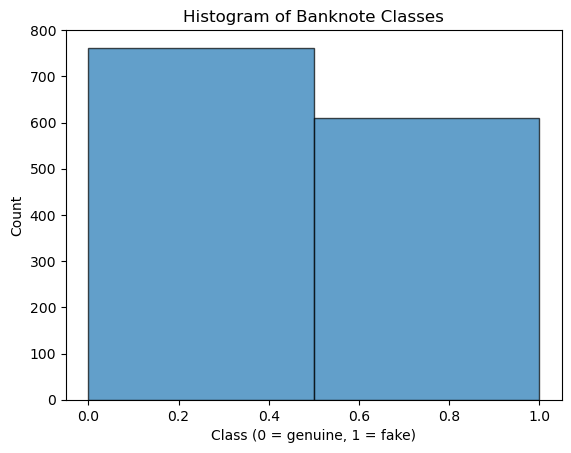

In [146]:
"""
     Produce 2–3 plots per dataset (histograms / pairwise scatter / boxplots) and describe any outliers/skew.
"""
import matplotlib.pyplot as plt
plt.hist(df.iloc[:, -1], bins=2, edgecolor="black", alpha=0.7)
plt.xlabel("Class (0 = genuine, 1 = fake)")
plt.ylabel("Count")
plt.title("Histogram of Banknote Classes")
plt.show()



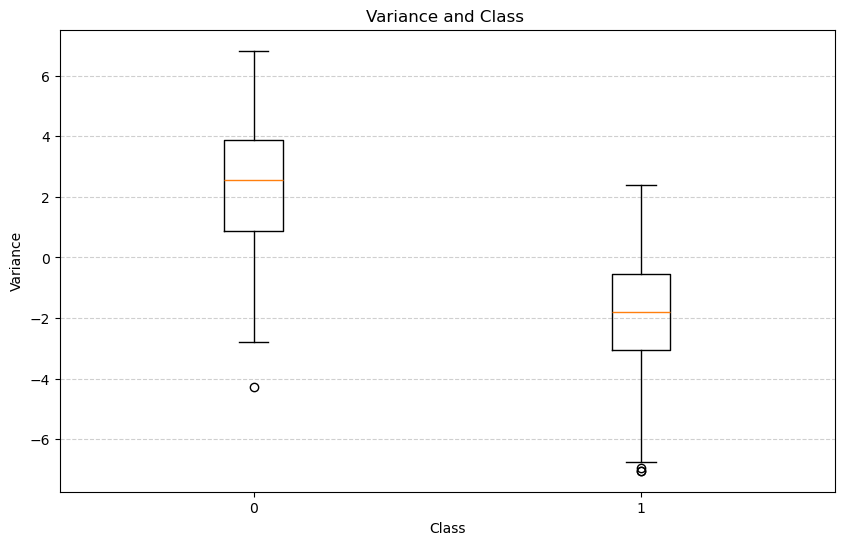

In [147]:
# Box Plot of class and variance
quality_groups = sorted(df['class'].unique())
data_to_plot = [df[df['class'] == q]['variance'] for q in quality_groups]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, tick_labels=quality_groups)
plt.title('Variance and Class ')
plt.xlabel('Class')
plt.ylabel('Variance')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Selecting Most and least correlated column with quality
class       1.000000
variance    0.724843
entropy     0.023424
Name: class, dtype: float64


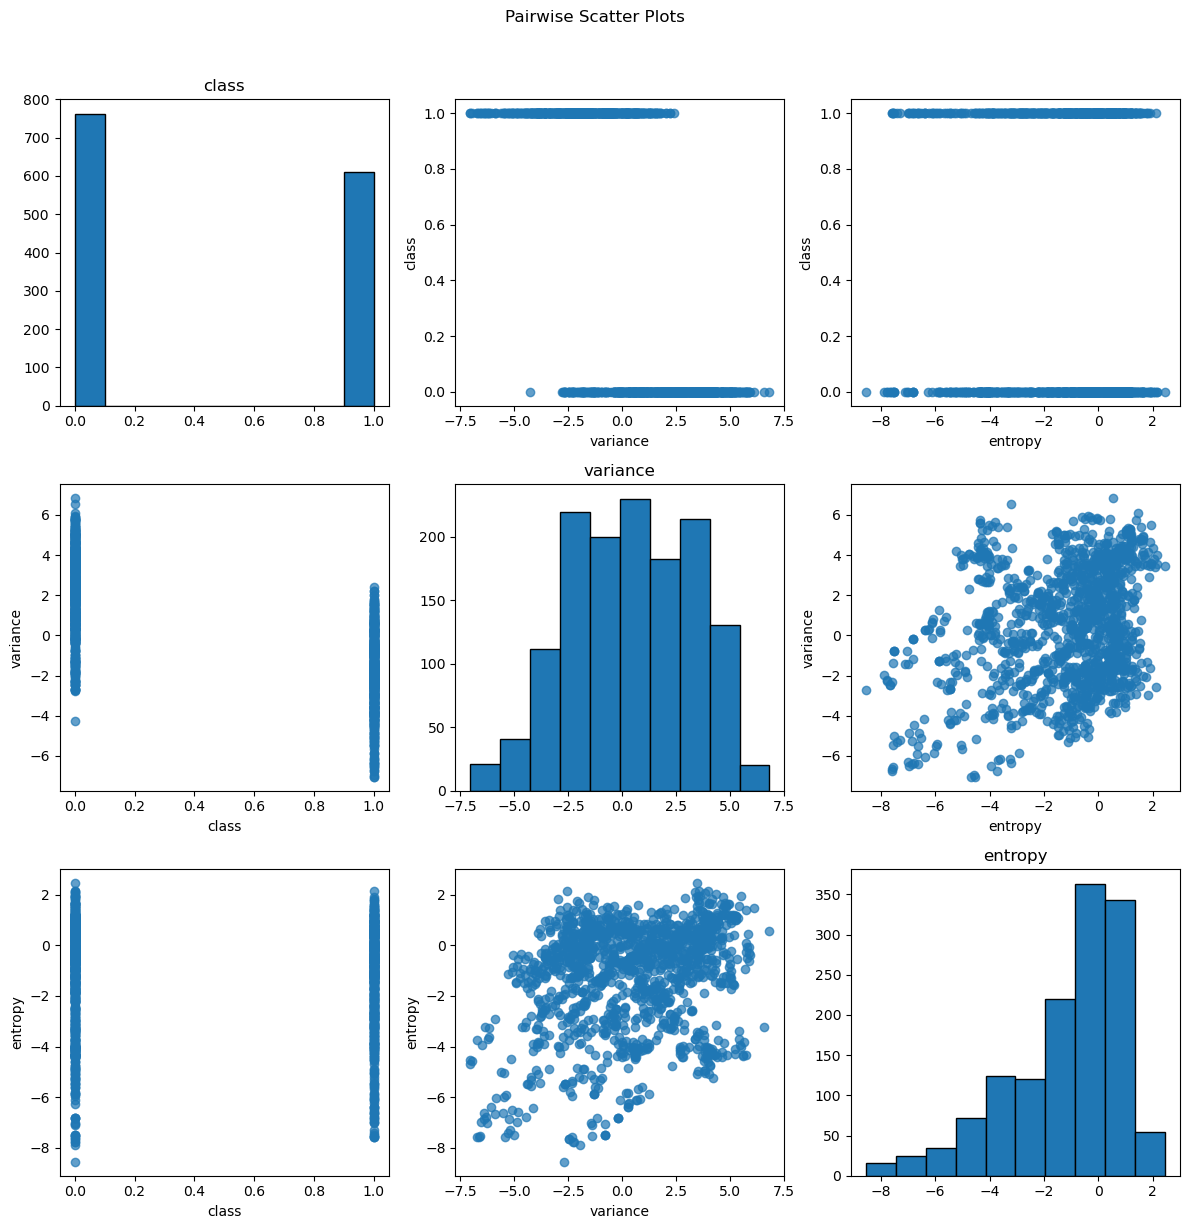

In [148]:
# Calculate the correlation matrix
corr_matrix = df.corr()
quality_correlations = corr_matrix.iloc[-1]
descending_correlated_features = quality_correlations.abs().sort_values(ascending=False)
three_features = descending_correlated_features.iloc[[0,1,-1]]
print("Selecting Most and least correlated column with quality")
print(three_features)
# 3. Get the list of column names from the Series index
columns_to_select = three_features.index.tolist()
new_df = df[columns_to_select]

# Pairwise scatter Plot
features =  new_df.columns.tolist()
n_features = len(features)
fig, axes = plt.subplots(n_features, n_features, figsize=(12, 12))

for i in range(n_features):
    for j in range(n_features):
        if i == j:
            # Plot histogram on the diagonal
            axes[i, j].hist(new_df[features[i]], bins=10, edgecolor='black')
            axes[i, j].set_title(features[i])
        else:
            # Plot scatter plot for off-diagonal
            axes[i, j].scatter(new_df[features[j]], new_df[features[i]], alpha=0.7)
            axes[i, j].set_xlabel(features[j])
            axes[i, j].set_ylabel(features[i])

plt.suptitle('Pairwise Scatter Plots', y=1.02)
plt.tight_layout()
plt.show()

# 2) Logistic Regression on Banknote (30 pts)


Gradient Descent Results:
 Accuracy=0.9781, Precision=0.9587, Recall=0.9915, F1=0.9748
 Confusion matrix:
 [[152   5]
 [  1 116]]

Newton Results:
 Accuracy=0.9927, Precision=0.9832, Recall=1.0000, F1=0.9915
 Confusion matrix:
 [[155   2]
 [  0 117]]


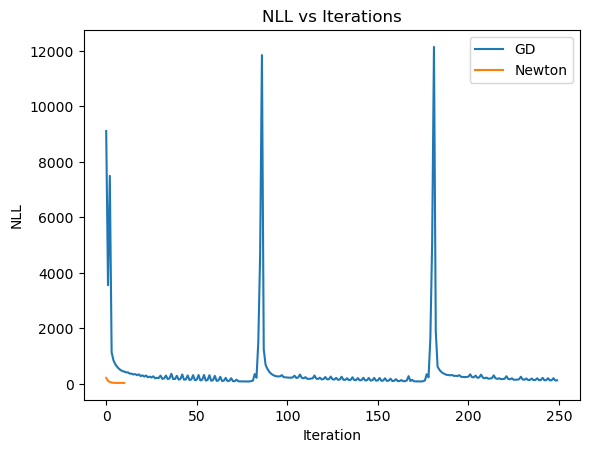

Gradient check:
 idx 2: analytic=9.770340e+01, numeric=9.770340e+01, rel_error=8.851876e-12
 idx 0: analytic=1.519111e+00, numeric=1.519111e+00, rel_error=5.696215e-10
 idx 4: analytic=-4.636125e+00, numeric=-4.636125e+00, rel_error=1.262273e-10


In [149]:


# --- Logistic Regression (binary) — Banknote  ---

def sigmoid(z):
    """
    Numerically stable logistic sigmoid.
    Tip: clip z to avoid overflow in exp for large |z|.
    """
    z = np.clip(z, -500, 500)  # prevent overflow
    return 1 / (1 + np.exp(-z))

def logreg_nll(X, y, w, lam=0.0):
    """
    Negative log-likelihood with optional L2 on w[1:].
    NLL = - sum_i [ y_i log p_i + (1-y_i) log (1-p_i) ] + (lam/2)*||w[1:]||^2
    Use epsilon inside logs for stability.
    """
    z = X @ w
    p = sigmoid(z)
    eps = 1e-15
    nll = -np.sum(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
    nll += (lam / 2) * np.sum(w[1:] ** 2)
    return nll
def fit_logreg_gd(X, y, lam=0.0, lr=0.1, iters=5000, add_bias=True):
    """
    Gradient descent for logistic regression (L2 on non-intercept).
    Return (w, losses)
    """
    if add_bias:
        X = np.hstack([np.ones((X.shape[0], 1)), X])

    w = np.zeros(X.shape[1])
    losses = []

    for t in range(iters):
        p = sigmoid(X @ w)
        grad = X.T @ (p - y) + lam * np.r_[0, w[1:]]
        w -= lr * grad
        losses.append(logreg_nll(X, y, w, lam))

    return w, losses
def fit_logreg_newton(X, y, lam=0.0, iters=100, tol=1e-6, add_bias=True, damping=1e-6):
    """
    Newton’s method (IRLS/Fisher scoring).
    Each step solves (H + damping*I) delta = grad; then w <- w - delta.
    Do not regularize intercept. Stop when change < tol.
    """
    if add_bias:
        X = np.hstack([np.ones((X.shape[0], 1)), X])

    w = np.zeros(X.shape[1])
    losses = []

    for t in range(iters):
        p = sigmoid(X @ w)
        grad = X.T @ (p - y) + lam * np.r_[0, w[1:]]
        W = np.diag(p * (1 - p))
        H = X.T @ W @ X + lam * np.diag(np.r_[0, np.ones(len(w) - 1)]) + damping * np.eye(len(w))
        delta = np.linalg.solve(H, grad)
        w -= delta
        losses.append(logreg_nll(X, y, w, lam))
        if np.linalg.norm(delta) < tol:
            break

    return w, losses

def predict_proba_logreg(X, w, has_bias=True):
    """Return predicted probabilities P(y=1|x)."""
    if has_bias:
        X = np.hstack([np.ones((X.shape[0], 1)), X])
    return sigmoid(X @ w)

def predict_logreg(X, w, threshold=0.5, has_bias=True):
    """Classify by thresholding predicted probabilities."""
    return (predict_proba_logreg(X, w, has_bias) >= threshold).astype(int)

# ----------------------------------------------------
# Metrics & confusion matrix
# ----------------------------------------------------

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def classification_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp + 1e-15)
    recall = tp / (tp + fn + 1e-15)
    f1 = 2 * precision * recall / (precision + recall + 1e-15)
    return accuracy, precision, recall, f1, cm

# ----------------------------------------------------
# Gradient check
# ----------------------------------------------------

def gradient_check(X, y, w, lam=0.0, eps=1e-5, num_checks=3):
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])
    p = sigmoid(Xb @ w)
    grad = Xb.T @ (p - y) + lam * np.r_[0, w[1:]]
    idxs = np.random.choice(len(w), num_checks, replace=False)

    print("Gradient check:")
    for idx in idxs:
        w_pos, w_neg = w.copy(), w.copy()
        w_pos[idx] += eps
        w_neg[idx] -= eps
        nll_pos = logreg_nll(Xb, y, w_pos, lam)
        nll_neg = logreg_nll(Xb, y, w_neg, lam)
        num_grad = (nll_pos - nll_neg) / (2 * eps)
        rel_error = abs(grad[idx] - num_grad) / max(1e-12, abs(grad[idx]) + abs(num_grad))
        print(f" idx {idx}: analytic={grad[idx]:.6e}, numeric={num_grad:.6e}, rel_error={rel_error:.6e}")

"""
• Train GD and Newton versions with L2 on weights (exclude intercept). Plot NLL vs itera-
tions.
• Report accuracy, precision, recall, F1 on test; include the confusion matrix.
• Gradient check: verify analytic gradient on 3 random coordinates via finite differences;
report relative error.
"""

# Train GD
w_gd, losses_gd = fit_logreg_gd(X_train, y_train, lam=1.0, lr=0.01, iters=250)
y_pred_gd = predict_logreg(X_test, w_gd)
acc, prec, rec, f1, cm = classification_report(y_test, y_pred_gd)
print("\nGradient Descent Results:")
print(f" Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
print(" Confusion matrix:\n", cm)

# Train Newton
w_newton, losses_newton = fit_logreg_newton(X_train, y_train, lam=1.0, iters=50)
y_pred_newton = predict_logreg(X_test, w_newton)
acc, prec, rec, f1, cm = classification_report(y_test, y_pred_newton)
print("\nNewton Results:")
print(f" Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
print(" Confusion matrix:\n", cm)

# Plot NLL vs iterations
plt.plot(losses_gd, label="GD")
plt.plot(losses_newton, label="Newton")
plt.xlabel("Iteration")
plt.ylabel("NLL")
plt.legend()
plt.title("NLL vs Iterations")
plt.show()

# Gradient check
gradient_check(X_train, y_train, w_gd, lam=1.0)



# (0) Iris Dataset - EDA & preprocessing

In [150]:
"""     a. Load each dataset.
        b. Handle missing values (drop/justify). 
        c. Print shapes and class/target summaries.
"""
# --- a. Load iris Dataset
print("\n$Loading dataset\n.")
import pandas as pd
data_path = 'iris.data'
raw_df = pd.read_csv(data_path, header=None)
# Add column names (optional, for clarity)
raw_df.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
print("..")
# --- b. Handle missing values
print("\n$Handling Missing values\n")
print("Missing values per column:")
print(raw_df.isna().sum())
df = raw_df.dropna()
# --- c. Print shapes and class/target summaries.
print("\n$Printing shapes and target summaries\n")
print("Dataset shape:", df.shape)
print("Dataset shape after dropping missing:", df.shape)
print(df["class"].value_counts())
print(df['class'].describe())



        


$Loading dataset
.
..

$Handling Missing values

Missing values per column:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
class           0
dtype: int64

$Printing shapes and target summaries

Dataset shape: (150, 5)
Dataset shape after dropping missing: (150, 5)
class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64
count             150
unique              3
top       Iris-setosa
freq               50
Name: class, dtype: object


In [151]:
"""
     Compute basic stats (mean/median/std/min/max) for numeric features.
"""
def analyze_all_columns(dataframe):
  """
  Iterates through all columns of a DataFrame and analyzes each one.

  Args:
    dataframe (pd.DataFrame): The DataFrame to analyze.
  """
  # This helper function is nested to keep the code organized
  def _analyze_column(df, col_name):
    """
    Checks if a column is numeric and, if so, computes descriptive statistics.
    """
    if pd.api.types.is_numeric_dtype(df[col_name]):
      print(f"Column '{col_name}' is numeric. Computing statistics...\n")
      
      # Compute the statistics
      stats = {
          "Mean": df[col_name].mean(),
          "Median": df[col_name].median(),
          "Standard Deviation": df[col_name].std(),
          "Minimum": df[col_name].min(),
          "Maximum": df[col_name].max()
      }
      
      # Print the results
      print(f"Statistics for column '{col_name}':")
      for stat, value in stats.items():
        print(f"  - {stat}: {value:.4f}")
      print("\n" + "-"*30 + "\n")
    else:
      print(f"Column '{col_name}' is not numeric. Skipping statistics calculation.\n")
  
  for col in dataframe.columns:
    _analyze_column(dataframe, col)
# Analyze all columns in the DataFrame
analyze_all_columns(df)


Column 'sepal_length' is numeric. Computing statistics...

Statistics for column 'sepal_length':
  - Mean: 5.8433
  - Median: 5.8000
  - Standard Deviation: 0.8281
  - Minimum: 4.3000
  - Maximum: 7.9000

------------------------------

Column 'sepal_width' is numeric. Computing statistics...

Statistics for column 'sepal_width':
  - Mean: 3.0540
  - Median: 3.0000
  - Standard Deviation: 0.4336
  - Minimum: 2.0000
  - Maximum: 4.4000

------------------------------

Column 'petal_length' is numeric. Computing statistics...

Statistics for column 'petal_length':
  - Mean: 3.7587
  - Median: 4.3500
  - Standard Deviation: 1.7644
  - Minimum: 1.0000
  - Maximum: 6.9000

------------------------------

Column 'petal_width' is numeric. Computing statistics...

Statistics for column 'petal_width':
  - Mean: 1.1987
  - Median: 1.3000
  - Standard Deviation: 0.7632
  - Minimum: 0.1000
  - Maximum: 2.5000

------------------------------

Column 'class' is not numeric. Skipping statistics calcu

In [152]:
"""
     Train/test split once per dataset (80/20, fixed seeds). Standardize using train stats only.
"""
import numpy as np

def add_intercept(X):
    """
    Return X with a leading column of ones (bias term).
    X: (n_samples, n_features) -> (n_samples, n_features + 1)
    Notes: ensure float dtype; do not modify X in-place.
    """
    X_out = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_out.astype(float)

def standardize_fit(X_train, eps=1e-12):
    """
    Standardize TRAIN features to zero mean / unit variance.
    Return (Xs, mean, std). Use only TRAIN stats.
    """
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_standardized = (X_train - mean) / (std + eps)
    return X_standardized, mean, std

def standardize_apply(X, mean, std, eps=1e-12):
    """
    [cite_start]Apply TRAIN (mean, std) to any new matrix X[cite: 32].
    [cite_start]Do not recompute mean/std here[cite: 32].
    """
    return (X - mean) / (std + eps)

def train_test_split_idx(n, test_size, seed=0):
    """
    Apply TRAIN (mean, std) to any new matrix X.
    Do not recompute mean/std here.
    """
    # Set the random seed for reproducibility
    np.random.seed(seed)
    print(f" Random Seed: {seed}")
    
    # Calculate the number of samples for the test set
    n_test = int(n * test_size)
    
    # Create an array of indices from 0 to n-1
    indices = np.arange(n)
    
    # Shuffle the indices
    np.random.shuffle(indices)
    
    # Split the shuffled indices into test and train sets
    test_idx = indices[:n_test]
    train_idx = indices[n_test:]
    
    return train_idx, test_idx

# Convert class labels to numeric codes
df["class_code"] = df["class"].astype("category").cat.codes
X = df.drop(['class', 'class_code'], axis=1).values
y = df['class_code'].values  # numeric labels (0,1,2)
# Train/test split using the custom function
n_samples = X.shape[0]
train_idx, test_idx = train_test_split_idx(n_samples, test_size=0.2, seed=0)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Standardize features using train stats only
X_train_std, mean_train, std_train = standardize_fit(X_train)
X_test_std = standardize_apply(X_test, mean_train, std_train)
print(f"Training dataset: {X_train_std.shape} Testing dataset: {X_test_std.shape}")


 Random Seed: 0
Training dataset: (120, 4) Testing dataset: (30, 4)


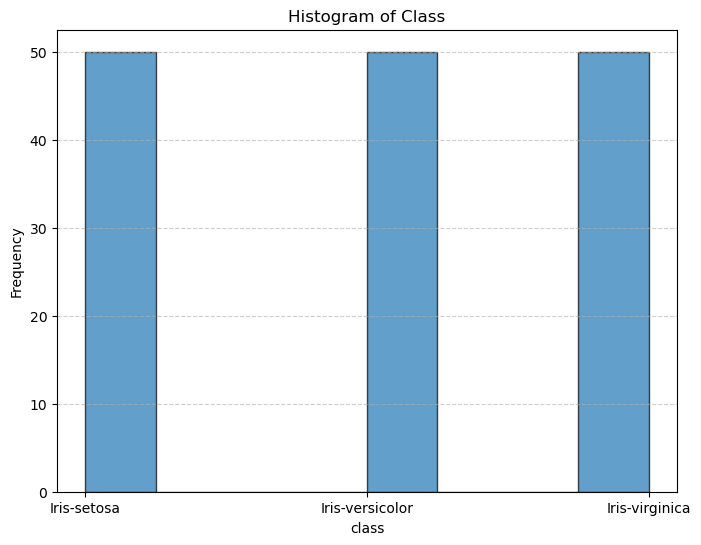

In [153]:
"""
     Produce 2–3 plots per dataset (histograms / pairwise scatter / boxplots) and describe any outliers/skew.
"""
import matplotlib.pyplot as plt

# Histogram of class
plt.figure(figsize=(8, 6))
plt.hist(df['class'], bins=8, edgecolor='black', alpha=0.7)
plt.title('Histogram of Class')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

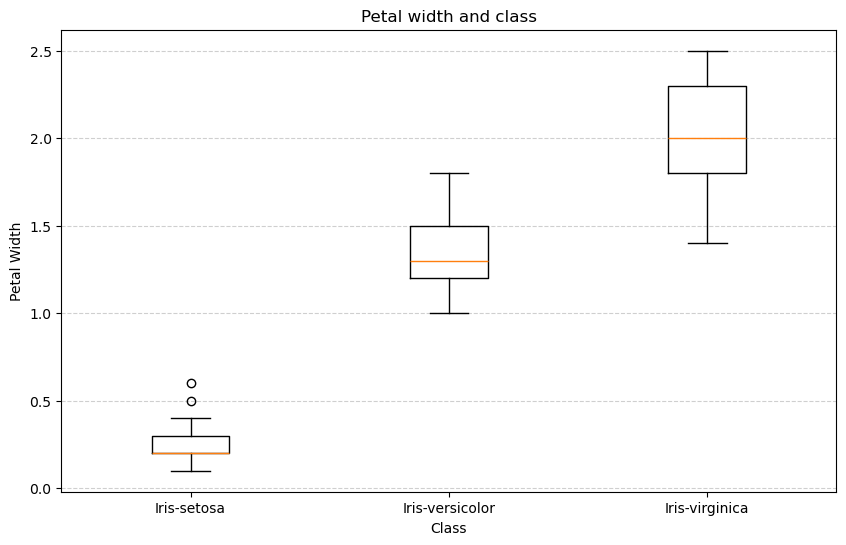

In [154]:
# Box Plot of wine quality and alcohol content
# To plot 'alcohol' for each unique 'quality' group
quality_groups = sorted(df['class'].unique())
data_to_plot = [df[df['class'] == q]['petal_width'] for q in quality_groups]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, tick_labels=quality_groups)
plt.title('Petal width and class')
plt.xlabel('Class')
plt.ylabel('Petal Width')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

class code:  [0 1 2]
class_code      1.000000
petal_width     0.956464
petal_length    0.949043
sepal_length    0.782561
sepal_width    -0.419446
Name: class_code, dtype: float64
Selecting Most and least correlated column with quality
class_code     1.000000
petal_width    0.956464
sepal_width    0.419446
Name: class_code, dtype: float64


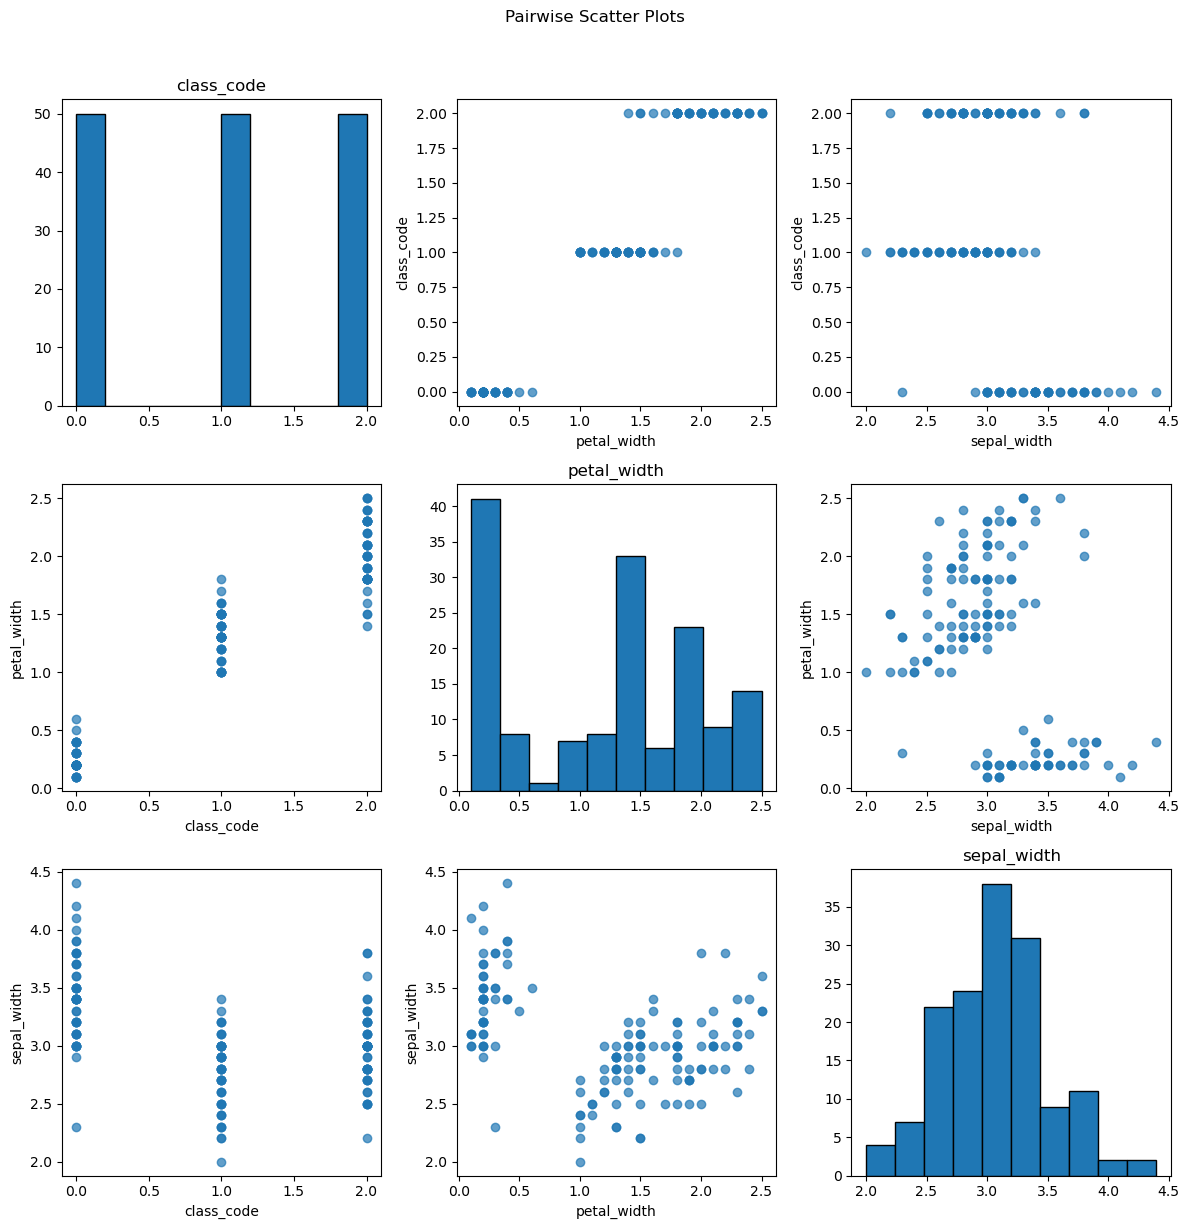

In [155]:
# Calculate the correlation matrix
num_df = df
num_df["class_code"] = df["class"].astype("category").cat.codes
print("class code: ",num_df["class_code"].unique())
corr_matrix = df.corr(numeric_only=True)
print(corr_matrix["class_code"].sort_values(ascending=False))
quality_correlations = corr_matrix['class_code']
descending_correlated_features = quality_correlations.abs().sort_values(ascending=False)
three_features = descending_correlated_features.iloc[[0,1,-1]]
print("Selecting Most and least correlated column with quality")
print(three_features)
# 3. Get the list of column names from the Series index
columns_to_select = three_features.index.tolist()
new_df = df[columns_to_select]

# Pairwise scatter Plot
features =  new_df.columns.tolist()
n_features = len(features)
fig, axes = plt.subplots(n_features, n_features, figsize=(12, 12))

for i in range(n_features):
    for j in range(n_features):
        if i == j:
            # Plot histogram on the diagonal
            axes[i, j].hist(new_df[features[i]], bins=10, edgecolor='black')
            axes[i, j].set_title(features[i])
        else:
            # Plot scatter plot for off-diagonal
            axes[i, j].scatter(new_df[features[j]], new_df[features[i]], alpha=0.7)
            axes[i, j].set_xlabel(features[j])
            axes[i, j].set_ylabel(features[i])

plt.suptitle('Pairwise Scatter Plots', y=1.02)
plt.tight_layout()
plt.show()

# 3) Decision Trees (35 pts)
"""Classification tree: Train on Iris. Tune max_depth and min_samples_leaf via 5-fold CV; evaluate test accuracy and the 3 × 3 confusion matrix. Visualize decision regions in 2D (choose two features; fix others at means)."""

In [156]:

# ---------------- Decision Tree Components ---------------- #

class DTNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None,
                 value=None, is_leaf=False):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.is_leaf = is_leaf

def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs + 1e-12))

def gini(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1.0 - np.sum(probs ** 2)

def mse_impurity(y):
    mean = np.mean(y)
    return np.mean((y - mean) ** 2)

def best_split(X, y, criterion="gini", min_samples_leaf=1):
    n_samples, n_features = X.shape
    if n_samples <= 1:
        return None, None, 0

    parent_impurity = gini(y) if criterion == "gini" else entropy(y)
    best_gain = 0
    best_feat, best_thr = None, None

    for feat in range(n_features):
        values = np.unique(X[:, feat])
        thresholds = (values[:-1] + values[1:]) / 2.0

        for thr in thresholds:
            left_mask = X[:, feat] <= thr
            right_mask = ~left_mask

            if sum(left_mask) < min_samples_leaf or sum(right_mask) < min_samples_leaf:
                continue

            left_impurity = gini(y[left_mask]) if criterion == "gini" else entropy(y[left_mask])
            right_impurity = gini(y[right_mask]) if criterion == "gini" else entropy(y[right_mask])

            n_left, n_right = sum(left_mask), sum(right_mask)
            child_impurity = (n_left * left_impurity + n_right * right_impurity) / n_samples
            gain = parent_impurity - child_impurity

            if gain > best_gain:
                best_gain = gain
                best_feat = feat
                best_thr = thr

    return best_feat, best_thr, best_gain

def majority_class(y):
    """Return the majority class in y (manual implementation)."""
    classes, counts = np.unique(y, return_counts=True)
    return classes[np.argmax(counts)]

def build_tree_classifier(X, y, max_depth=None, min_samples_split=2,
                          min_samples_leaf=1, criterion="gini", depth=0):
    # Stopping conditions
    if (max_depth is not None and depth >= max_depth) or len(np.unique(y)) == 1 or len(y) < min_samples_split:
        return DTNode(value=majority_class(y), is_leaf=True)

    feat, thr, gain = best_split(X, y, criterion, min_samples_leaf)

    if gain == 0 or feat is None:
        return DTNode(value=majority_class(y), is_leaf=True)

    left_mask = X[:, feat] <= thr
    right_mask = ~left_mask

    left_child = build_tree_classifier(X[left_mask], y[left_mask],
                                       max_depth, min_samples_split,
                                       min_samples_leaf, criterion, depth + 1)
    right_child = build_tree_classifier(X[right_mask], y[right_mask],
                                        max_depth, min_samples_split,
                                        min_samples_leaf, criterion, depth + 1)

    return DTNode(feature=feat, threshold=thr, left=left_child, right=right_child)

def predict_tree(X, tree):
    preds = []
    for x in X:
        node = tree
        while not node.is_leaf:
            if x[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        preds.append(node.value)
    return np.array(preds)


# ---------------- Training & Evaluation ---------------- #

# X_train_std, X_test_std, y_train, y_test are already available

# Train a tree
tree = build_tree_classifier(X_train_std, y_train, max_depth=3, min_samples_leaf=2)

# Predict
y_pred = predict_tree(X_test_std, tree)

# Confusion matrix
n_classes = len(np.unique(y_train))
conf_mat = np.zeros((n_classes, n_classes), dtype=int)
for true, pred in zip(y_test, y_pred):
    conf_mat[true, pred] += 1

acc = np.mean(y_pred == y_test)

print("Confusion Matrix:\n", conf_mat)
print("Test Accuracy:", acc)


Confusion Matrix:
 [[11  0  0]
 [ 0 13  0]
 [ 0  1  5]]
Test Accuracy: 0.9666666666666667


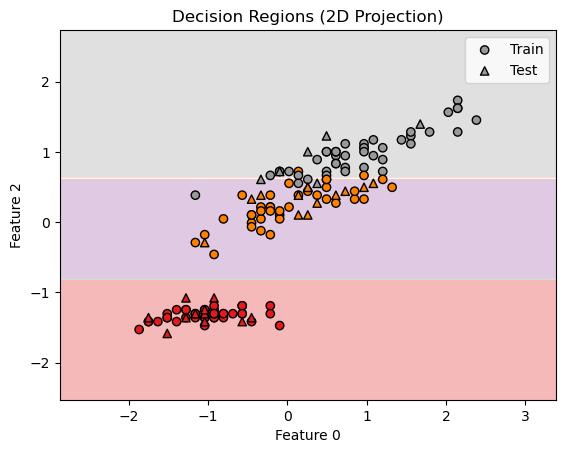

In [157]:
import matplotlib.pyplot as plt

def plot_decision_regions(X_train, y_train, X_test, y_test, tree, feat_idx=(0, 2)):
    """
    Visualize decision regions using two chosen features.
    Other features fixed at train means.
    """
    # Pick two features
    f1, f2 = feat_idx
    mean_vec = np.mean(X_train, axis=0)

    # Define ranges for grid
    x_min, x_max = X_train[:, f1].min() - 1, X_train[:, f1].max() + 1
    y_min, y_max = X_train[:, f2].min() - 1, X_train[:, f2].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    # Build grid input with other features fixed at mean
    grid = np.tile(mean_vec, (xx.size, 1))
    grid[:, f1] = xx.ravel()
    grid[:, f2] = yy.ravel()

    # Predict labels for the grid
    Z = predict_tree(grid, tree)
    Z = Z.reshape(xx.shape)

    # Plot decision regions
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)

    # Plot train and test points
    plt.scatter(X_train[:, f1], X_train[:, f2], c=y_train, cmap=plt.cm.Set1, edgecolor='k', label="Train", marker="o")
    plt.scatter(X_test[:, f1], X_test[:, f2], c=y_test, cmap=plt.cm.Set1, edgecolor='k', label="Test", marker="^")

    plt.xlabel(f"Feature {f1}")
    plt.ylabel(f"Feature {f2}")
    plt.legend()
    plt.title("Decision Regions (2D Projection)")
    plt.show()


# usage:
plot_decision_regions(X_train_std, y_train, X_test_std, y_test, tree, feat_idx=(0, 2))


# (0) Wine Dataset - EDA & preprocessing

In [158]:
"""     a. Load each dataset.
        b. Handle missing values (drop/justify). 
        c. Print shapes and class/target summaries.
"""
# --- a. Load Wine Dataset
print("\n$Loading dataset\n.")
import pandas as pd
data_path = 'winequality-red.csv'
raw_df = pd.read_csv(data_path, sep=';')
print("..")
# --- b. Handle missing values
print("\n$Handling Missing values\n")
print("Missing values per column:")
print(raw_df.isna().sum())
df = raw_df.dropna()
# --- c. Print shapes and class/target summaries.
print("\n$Printing shapes and target summaries\n")
print("Dataset shape:", df.shape)
print("Dataset shape after dropping missing:", df.shape)
print(df['quality'].describe())



        


$Loading dataset
.
..

$Handling Missing values

Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

$Printing shapes and target summaries

Dataset shape: (1599, 12)
Dataset shape after dropping missing: (1599, 12)
count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64


In [159]:
"""
     Compute basic stats (mean/median/std/min/max) for numeric features.
"""
def analyze_all_columns(dataframe):
  """
  Iterates through all columns of a DataFrame and analyzes each one.

  Args:
    dataframe (pd.DataFrame): The DataFrame to analyze.
  """
  # This helper function is nested to keep the code organized
  def _analyze_column(df, col_name):
    """
    Checks if a column is numeric and, if so, computes descriptive statistics.
    """
    if pd.api.types.is_numeric_dtype(df[col_name]):
      print(f"Column '{col_name}' is numeric. Computing statistics...\n")
      
      # Compute the statistics
      stats = {
          "Mean": df[col_name].mean(),
          "Median": df[col_name].median(),
          "Standard Deviation": df[col_name].std(),
          "Minimum": df[col_name].min(),
          "Maximum": df[col_name].max()
      }
      
      # Print the results
      print(f"Statistics for column '{col_name}':")
      for stat, value in stats.items():
        print(f"  - {stat}: {value:.4f}")
      print("\n" + "-"*30 + "\n")
    else:
      print(f"Column '{col_name}' is not numeric. Skipping statistics calculation.\n")
  
  for col in dataframe.columns:
    _analyze_column(dataframe, col)
# Analyze all columns in the DataFrame
analyze_all_columns(df)


Column 'fixed acidity' is numeric. Computing statistics...

Statistics for column 'fixed acidity':
  - Mean: 8.3196
  - Median: 7.9000
  - Standard Deviation: 1.7411
  - Minimum: 4.6000
  - Maximum: 15.9000

------------------------------

Column 'volatile acidity' is numeric. Computing statistics...

Statistics for column 'volatile acidity':
  - Mean: 0.5278
  - Median: 0.5200
  - Standard Deviation: 0.1791
  - Minimum: 0.1200
  - Maximum: 1.5800

------------------------------

Column 'citric acid' is numeric. Computing statistics...

Statistics for column 'citric acid':
  - Mean: 0.2710
  - Median: 0.2600
  - Standard Deviation: 0.1948
  - Minimum: 0.0000
  - Maximum: 1.0000

------------------------------

Column 'residual sugar' is numeric. Computing statistics...

Statistics for column 'residual sugar':
  - Mean: 2.5388
  - Median: 2.2000
  - Standard Deviation: 1.4099
  - Minimum: 0.9000
  - Maximum: 15.5000

------------------------------

Column 'chlorides' is numeric. Computi

In [160]:
"""
     Train/test split once per dataset (80/20, fixed seeds). Standardize using train stats only.
"""
import numpy as np

def add_intercept(X):
    """
    Return X with a leading column of ones (bias term).
    X: (n_samples, n_features) -> (n_samples, n_features + 1)
    Notes: ensure float dtype; do not modify X in-place.
    """
    X_out = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_out.astype(float)

def standardize_fit(X_train, eps=1e-12):
    """
    Standardize TRAIN features to zero mean / unit variance.
    Return (Xs, mean, std). Use only TRAIN stats.
    """
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_standardized = (X_train - mean) / (std + eps)
    return X_standardized, mean, std

def standardize_apply(X, mean, std, eps=1e-12):
    """
    [cite_start]Apply TRAIN (mean, std) to any new matrix X[cite: 32].
    [cite_start]Do not recompute mean/std here[cite: 32].
    """
    return (X - mean) / (std + eps)

def train_test_split_idx(n, test_size, seed=0):
    """
    Apply TRAIN (mean, std) to any new matrix X.
    Do not recompute mean/std here.
    """
    # Set the random seed for reproducibility
    np.random.seed(seed)
    print(f" Random Seed: {seed}")
    
    # Calculate the number of samples for the test set
    n_test = int(n * test_size)
    
    # Create an array of indices from 0 to n-1
    indices = np.arange(n)
    
    # Shuffle the indices
    np.random.shuffle(indices)
    
    # Split the shuffled indices into test and train sets
    test_idx = indices[:n_test]
    train_idx = indices[n_test:]
    
    return train_idx, test_idx

X = df.drop('quality', axis=1).values
y = df['quality'].values

# Train/test split using the custom function
n_samples = X.shape[0]
train_idx, test_idx = train_test_split_idx(n_samples, test_size=0.2, seed=0)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Standardize features using train stats only
X_train_std, mean_train, std_train = standardize_fit(X_train)
X_test_std = standardize_apply(X_test, mean_train, std_train)
print(f"Training dataset: {X_train_std.shape} Testing dataset: {X_test_std.shape}")


 Random Seed: 0
Training dataset: (1280, 11) Testing dataset: (319, 11)


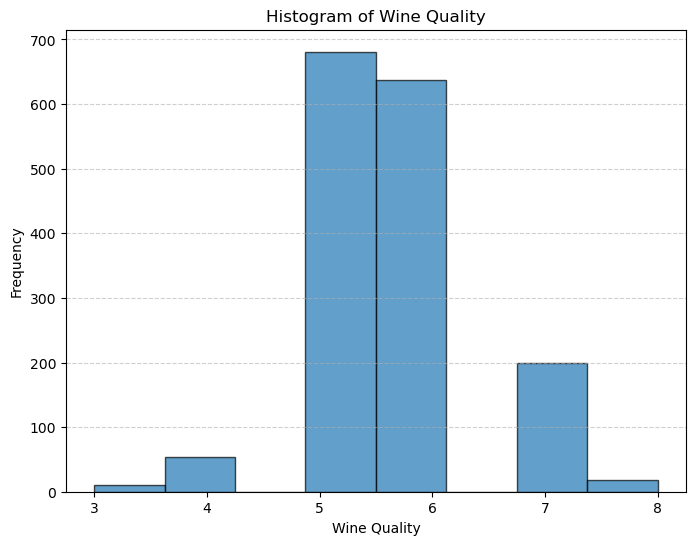

In [161]:
"""
     Produce 2–3 plots per dataset (histograms / pairwise scatter / boxplots) and describe any outliers/skew.
"""
import matplotlib.pyplot as plt

# Histogram of Wine Quality
plt.figure(figsize=(8, 6))
plt.hist(df['quality'], bins=8, edgecolor='black', alpha=0.7)
plt.title('Histogram of Wine Quality')
plt.xlabel('Wine Quality')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

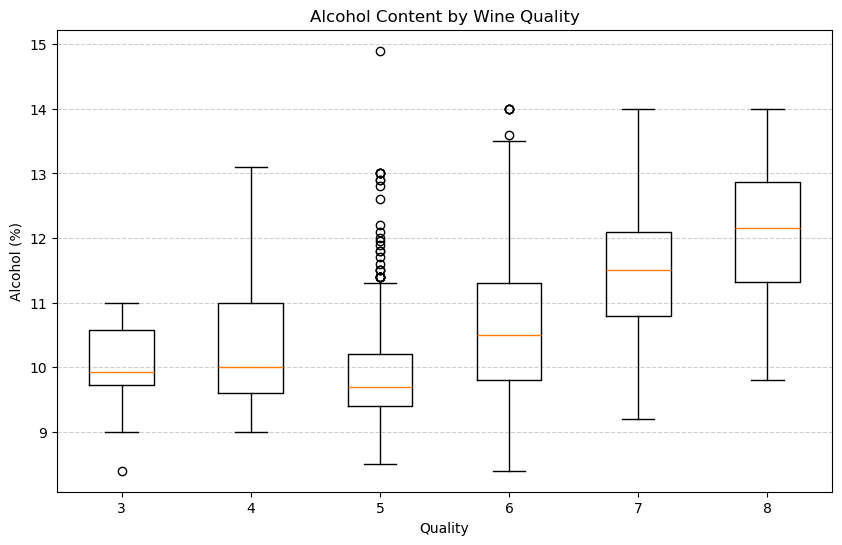

In [162]:
# Box Plot of wine quality and alcohol content
# To plot 'alcohol' for each unique 'quality' group
quality_groups = sorted(df['quality'].unique())
data_to_plot = [df[df['quality'] == q]['alcohol'] for q in quality_groups]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, tick_labels=quality_groups)
plt.title('Alcohol Content by Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Alcohol (%)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Selecting Most and least correlated column with quality
quality           1.000000
alcohol           0.476166
residual sugar    0.013732
Name: quality, dtype: float64


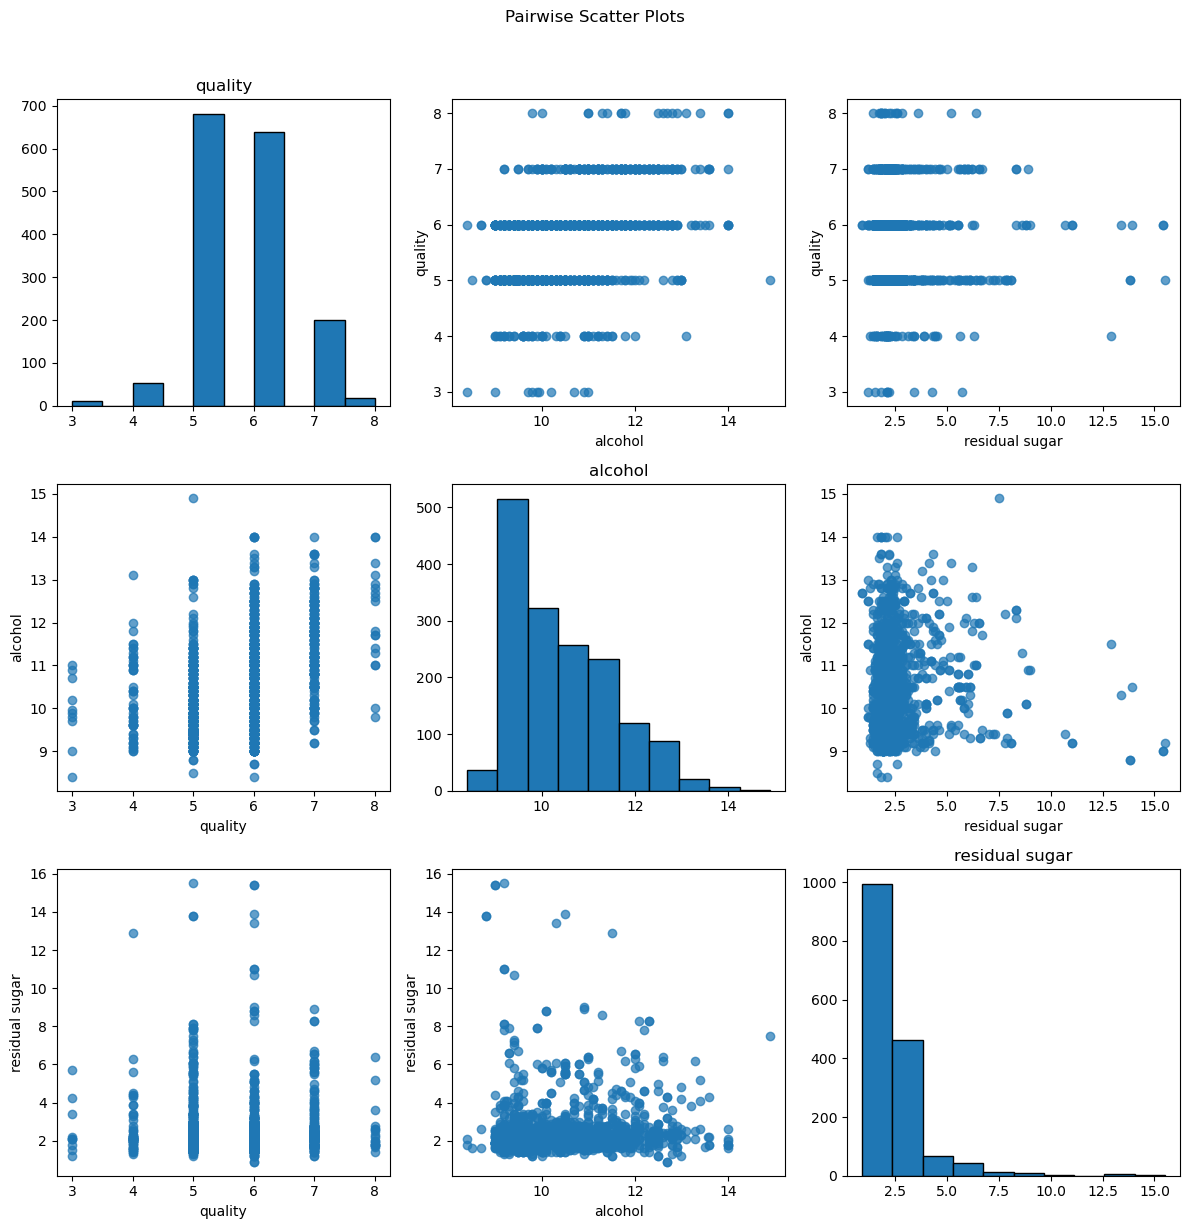

In [163]:
# Calculate the correlation matrix
corr_matrix = df.corr()
quality_correlations = corr_matrix['quality']
descending_correlated_features = quality_correlations.abs().sort_values(ascending=False)
three_features = descending_correlated_features.iloc[[0,1,-1]]
print("Selecting Most and least correlated column with quality")
print(three_features)
# 3. Get the list of column names from the Series index
columns_to_select = three_features.index.tolist()
new_df = df[columns_to_select]

# Pairwise scatter Plot
features =  new_df.columns.tolist()
n_features = len(features)
fig, axes = plt.subplots(n_features, n_features, figsize=(12, 12))

for i in range(n_features):
    for j in range(n_features):
        if i == j:
            # Plot histogram on the diagonal
            axes[i, j].hist(new_df[features[i]], bins=10, edgecolor='black')
            axes[i, j].set_title(features[i])
        else:
            # Plot scatter plot for off-diagonal
            axes[i, j].scatter(new_df[features[j]], new_df[features[i]], alpha=0.7)
            axes[i, j].set_xlabel(features[j])
            axes[i, j].set_ylabel(features[i])

plt.suptitle('Pairwise Scatter Plots', y=1.02)
plt.tight_layout()
plt.show()

# Regression tree: Train on Wine to predict quality. Compare test MSE/R2 vs. linear regression. Discuss when a tree helps/hurts and signs of overfitting.


$ Closed form Loss and R^2 for training and testing

Closed-form MSE (Train): 0.4256
Closed-form MSE (Test): 0.3852

Closed-form R^2 (Train): 0.3654
Closed-form R^2 (Test): 0.3286
Closed-form Weight Vector: [ 5.646875    0.07251889 -0.20942866 -0.03492666  0.04067697 -0.08974311
  0.02846893 -0.09315737 -0.06000062 -0.03860717  0.16198752  0.28344618]

$ GD Loss and R^2 for training and testing

GD MSE (Train): 0.4256
GD MSE (Test): 0.3852

GD R^2 (Train): 0.4256
GD R^2 (Test): 0.3286
GD Weight vector: [ 5.646875    0.07375155 -0.20926837 -0.03482901  0.04111393 -0.08971745
  0.02844326 -0.09314372 -0.06129106 -0.03790011  0.16219733  0.28266921]


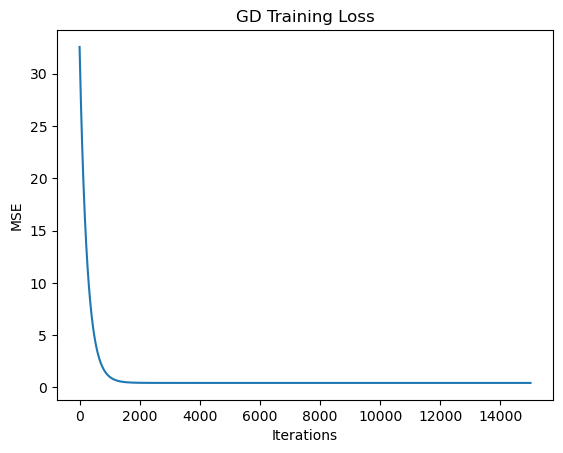

In [164]:
# --- Task 1: Linear Regression (MLE) on Wine ---

# --- Linear Regression (MLE) Functions ---

def mse(y, yhat):
    """Mean squared error: average of (y-yhat)^2 (1D arrays)."""
    return np.mean((y - yhat)**2)

def r2_score(y, yhat):
    """
    SS_res/SS_tot; handle constant-y edge case safely.
    SS_res = sum((y - yhat)^2)
    SS_tot = sum((y - mean(y))^2)
    R^2 = 1 - (SS_res / SS_tot)
    """
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    if ss_tot == 0:
        return 1.0
    return 1 - (ss_res / ss_tot)

def fit_linear_closed_form(X, y, add_bias=True, rcond=None):
    """
    Closed-form least squares (MLE) using pseudoinverse or solve.
    *If add_bias: prepend ones.
    *Prefer pinv for numerical stability when X^T X is ill-conditioned.
    Return w (length p [+1 if bias]).
    """
    if add_bias:
        X = add_intercept(X)
    w = np.linalg.pinv(X.T @ X) @ X.T @ y
    return w

def fit_linear_gd(X, y, lr=0.001, iters=15000, add_bias=True):
    """
    Batch gradient descent for least squares.
    Return (w, losses).
    """
    if add_bias:
        X = add_intercept(X)
    n, p = X.shape
    w = np.zeros(p)
    losses = []
    for _ in range(iters):
        yhat = X @ w
        gradient = (2 / n) * X.T @ (yhat - y)
        w -= lr * gradient
        losses.append(mse(y, yhat))
    return w, losses

def predict_linear(X, w, has_bias=True):
    """Predict with linear model; add bias column if has_bias. Return 1D yhat."""
    if has_bias:
        X = add_intercept(X)
    return X @ w
""" 
    Implement closed-form and GD solvers. Plot GD training loss and discuss convergence behaviour.
"""

# Closed-form solution
w_closed_form = fit_linear_closed_form(X_train_std, y_train)
yhat_train_cf = predict_linear(X_train_std, w_closed_form)
yhat_test_cf = predict_linear(X_test_std, w_closed_form)
print("\n$ Closed form Loss and R^2 for training and testing\n")
print(f"Closed-form MSE (Train): {mse(y_train, yhat_train_cf):.4f}")
print(f"Closed-form MSE (Test): {mse(y_test, yhat_test_cf):.4f}\n")
print(f"Closed-form R^2 (Train): {r2_score(y_train, yhat_train_cf):.4f}")
print(f"Closed-form R^2 (Test): {r2_score(y_test, yhat_test_cf):.4f}")
print(f"Closed-form Weight Vector: {w_closed_form}")

# Gradient descent solution
w_gd, gd_losses = fit_linear_gd(X_train_std, y_train)
yhat_train_gd = predict_linear(X_train_std, w_gd)
yhat_test_gd = predict_linear(X_test_std, w_gd)
print("\n$ GD Loss and R^2 for training and testing\n")
print(f"GD MSE (Train): {mse(y_train, yhat_train_gd):.4f}")
print(f"GD MSE (Test): {mse(y_test, yhat_test_gd):.4f}\n")
print(f"GD R^2 (Train): {mse(y_train, yhat_train_gd):.4f}")
print(f"GD R^2 (Test): {r2_score(y_test, yhat_test_gd):.4f}")
print(f"GD Weight vector: {w_gd}")

"""
    • Report MSE and R2 on train/test; compare coefficient vectors and interpret influential features.
"""

# Plot GD training loss
plt.figure()
plt.plot(gd_losses)
plt.title("GD Training Loss")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

Regression tree: Train on Wine to predict quality. Compare test MSE/R2 vs. linear
regression. Discuss when a tree helps/hurts and signs of overfitting.


Regression Tree:
 MSE: 0.4226343402330494
 R2 : 0.26336508124733937

$ Linear Regression
GD MSE (Test): 0.3852
GD R^2 (Test): 0.3286


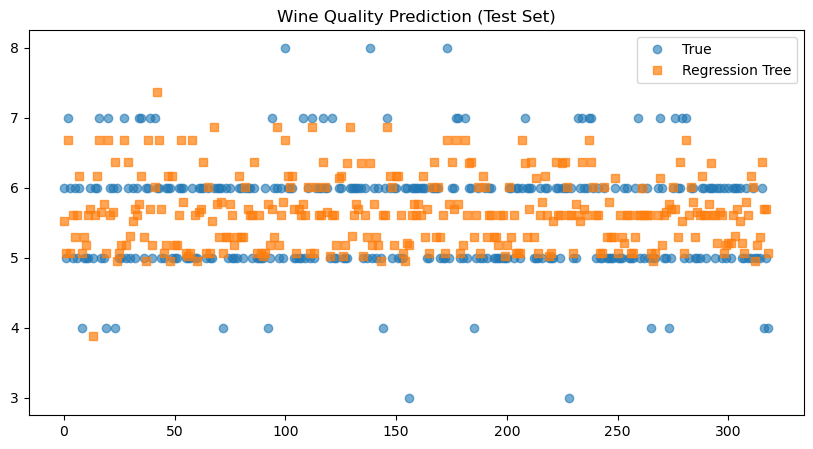

In [165]:
 #---------------------------
#  Regression Tree (Scratch)
# ---------------------------

class RegressionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class RegressionTree:
    def __init__(self, max_depth=5, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape

        # Stopping criteria
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return RegressionTreeNode(value=np.mean(y))

        # Best split search
        best_feature, best_threshold, best_loss = None, None, float("inf")
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_idx = X[:, feature] <= t
                right_idx = X[:, feature] > t
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                loss = (len(y[left_idx]) * np.var(y[left_idx]) + 
                        len(y[right_idx]) * np.var(y[right_idx]))
                if loss < best_loss:
                    best_loss = loss
                    best_feature = feature
                    best_threshold = t

        if best_feature is None:
            return RegressionTreeNode(value=np.mean(y))

        # Split
        left_idx = X[:, best_feature] <= best_threshold
        right_idx = X[:, best_feature] > best_threshold
        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[right_idx], y[right_idx], depth + 1)
        return RegressionTreeNode(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)

    def predict(self, X):
        return np.array([self.predict_one(sample, self.root) for sample in X])

# Regression Tree
tree = RegressionTree(max_depth=5, min_samples_split=10)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# ---------------------------
#  Evaluation
# ---------------------------

print("\nRegression Tree:")
print(" MSE:", mse(y_test, y_pred_tree))
print(" R2 :", r2_score(y_test, y_pred_tree))

print("\n$ Linear Regression")
print(f"GD MSE (Test): {mse(y_test, yhat_test_gd):.4f}")
print(f"GD R^2 (Test): {r2_score(y_test, yhat_test_gd):.4f}")

# ---------------------------
#  Plot Predictions
# ---------------------------

plt.figure(figsize=(10,5))
plt.plot(y_test, "o", label="True", alpha=0.6)
#plt.plot(y_pred_lin, "x", label="Linear Regression")
plt.plot(y_pred_tree, "s", label="Regression Tree", alpha=0.7)
plt.legend()
plt.title("Wine Quality Prediction (Test Set)")
plt.show()